Analysis of Google stock

Data collected from 'https://finance.yahoo.com/quote/GOOGL/history?p=GOOGL', from 2017 to end of 2022.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [30]:
goog = pd.read_csv('../datasets/GOOG.csv')

In [31]:
goog.Date = pd.to_datetime(goog['Date'])
goog = goog.set_index('Date')

goog.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1510 entries, 2017-01-03 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1510 non-null   float64
 1   High       1510 non-null   float64
 2   Low        1510 non-null   float64
 3   Close      1510 non-null   float64
 4   Adj Close  1510 non-null   float64
 5   Volume     1510 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 82.6 KB


In [32]:
goog.shape

(1510, 6)

In [33]:
goog.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,38.940498,39.481499,38.790001,39.306999,39.306999,33146000
2017-01-04,39.417999,39.567001,39.158001,39.345001,39.345001,21460000
2017-01-05,39.304001,39.723999,39.250999,39.701000,39.701000,26704000
2017-01-06,39.763000,40.395000,39.610199,40.307499,40.307499,32804000
2017-01-09,40.320000,40.498299,40.141499,40.332500,40.332500,25492000


In [34]:
goog.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1510.000000,1510.000000,1510.000000,1510.000000,1510.000000,1.510000e+03
mean,79.306040,80.162419,78.489687,79.337876,79.337876,3.073554e+07
std,32.229300,32.592655,31.841737,32.200557,32.200557,1.338655e+07
min,38.940498,39.481499,38.790001,39.306999,39.306999,6.936000e+06
25%,54.179001,54.727437,53.610687,54.157625,54.157625,2.216500e+07
50%,64.674000,65.253246,64.087502,64.765499,64.765499,2.727390e+07
75%,104.174875,105.740997,103.271124,104.766373,104.766373,3.479412e+07
max,151.863495,152.100006,149.887497,150.709000,150.709000,1.241400e+08


No difference between Close and Adj Close. Will drop close and rename adj close to close.

In [35]:
goog[((goog.Close - goog['Adj Close']) < 0) | ((goog.Close - goog['Adj Close'])) > 0].count()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [36]:
goog = goog.drop(['Close'], axis='columns')
goog = goog.rename(columns={'Adj Close': 'Close'})
goog.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,38.940498,39.481499,38.790001,39.306999,33146000
2017-01-04,39.417999,39.567001,39.158001,39.345001,21460000
2017-01-05,39.304001,39.723999,39.250999,39.701000,26704000
2017-01-06,39.763000,40.395000,39.610199,40.307499,32804000
2017-01-09,40.320000,40.498299,40.141499,40.332500,25492000


<Axes: xlabel='Date'>

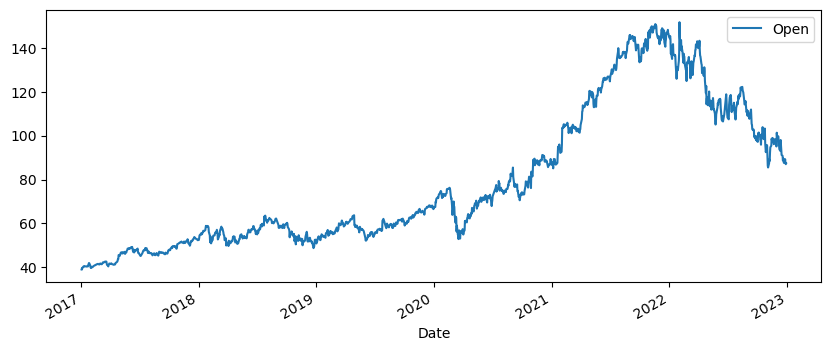

In [37]:
goog['Open'].plot(legend=True, figsize=(10,4))

<Axes: xlabel='Date'>

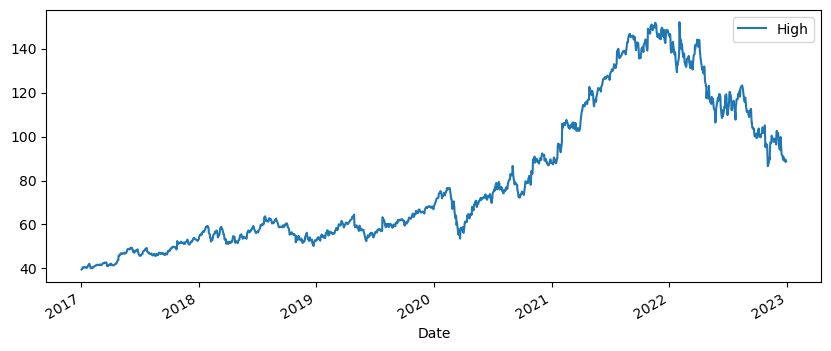

In [38]:
goog['High'].plot(legend=True, figsize=(10,4))

<Axes: xlabel='Date'>

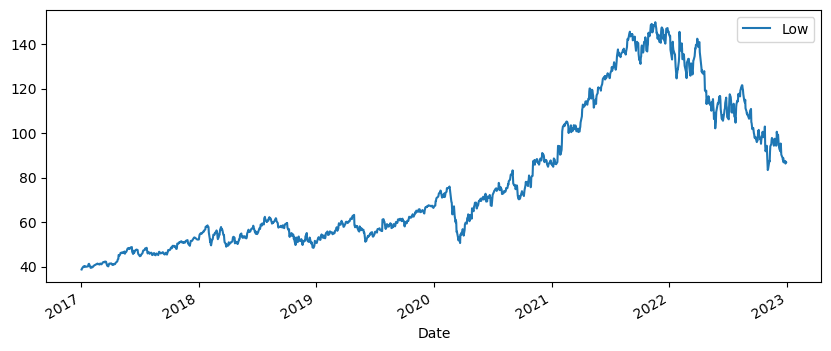

In [39]:
goog['Low'].plot(legend=True, figsize=(10,4))

<Axes: xlabel='Date'>

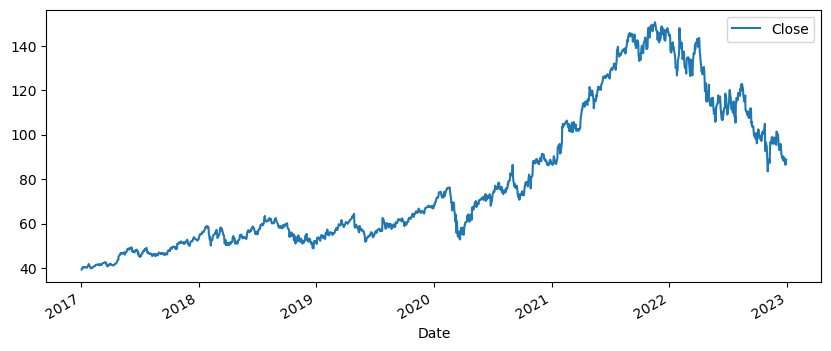

In [40]:
goog['Close'].plot(legend=True, figsize=(10,4))

Seems to be cyclic

<Axes: xlabel='Date'>

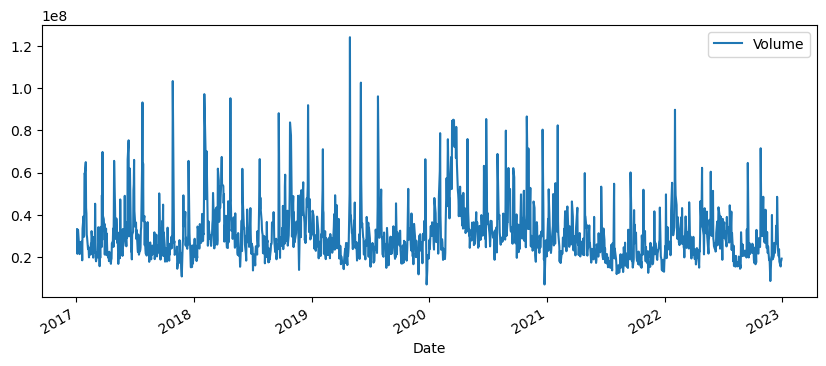

In [41]:
goog['Volume'].plot(legend=True, figsize=(10,4))